# Exploratory notebook 
The goal of this notebook is to conduct the research part of "predicting the results of a match". Importing data from past seasons, transforming that data to extract new indicators (prétraitement et EDA), developping and evaluating models.

## Load packages and transform data

In [2]:

import pandas as pd             # manipulation de données tabulaires
import sys
import os
import json                     # pour afficher proprement le JSON si besoin
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))


In [3]:
from src.etl import fetch_matches, save_raw_matches

In [4]:
matches_json=fetch_matches(2015,2024) #Ligue 1 saison 2024-2025

save_raw_matches(matches_json)

'data/raw/FL1_2024.json'

In [5]:
matches_list = matches_json["matches"]
df_matches = pd.json_normalize(matches_list)

In [6]:
df_matches.head()

,id,utcDate,status,matchday,stage,group,lastUpdated,referees,area.id,area.name,...,awayTeam.shortName,awayTeam.tla,awayTeam.crest,score.winner,score.duration,score.fullTime.home,score.fullTime.away,score.halfTime.home,score.halfTime.away,odds.msg
0,497958,2024-08-16T18:45:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 57042, 'name': 'Willy Delajod', 'type'...",2081,France,...,PSG,PSG,https://crests.football-data.org/524.png,AWAY_TEAM,REGULAR,1,4,0,1,Activate Odds-Package in User-Panel to retriev...
1,497951,2024-08-17T15:00:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 43926, 'name': 'Benoît Bastien', 'type...",2081,France,...,Marseille,MAR,https://crests.football-data.org/516.png,AWAY_TEAM,REGULAR,1,5,1,3,Activate Odds-Package in User-Panel to retriev...
2,497956,2024-08-17T17:00:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 57092, 'name': 'Eric Wattellier', 'typ...",2081,France,...,Lille,LIL,https://crests.football-data.org/521.png,AWAY_TEAM,REGULAR,0,2,0,1,Activate Odds-Package in User-Panel to retriev...
3,497955,2024-08-17T19:00:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 9374, 'name': 'Clément Turpin', 'type'...",2081,France,...,Saint-Étienne,ASS,https://crests.football-data.org/527.png,HOME_TEAM,REGULAR,1,0,1,0,Activate Odds-Package in User-Panel to retriev...
4,497957,2024-08-18T13:00:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 57087, 'name': 'Romain Lissorgue', 'ty...",2081,France,...,Nice,NIC,https://crests.football-data.org/522.png,HOME_TEAM,REGULAR,2,1,1,1,Activate Odds-Package in User-Panel to retriev...


In [7]:
df_matches.columns


Index(['id', 'utcDate', 'status', 'matchday', 'stage', 'group', 'lastUpdated',
       'referees', 'area.id', 'area.name', 'area.code', 'area.flag',
       'competition.id', 'competition.name', 'competition.code',
       'competition.type', 'competition.emblem', 'season.id',
       'season.startDate', 'season.endDate', 'season.currentMatchday',
       'season.winner', 'homeTeam.id', 'homeTeam.name', 'homeTeam.shortName',
       'homeTeam.tla', 'homeTeam.crest', 'awayTeam.id', 'awayTeam.name',
       'awayTeam.shortName', 'awayTeam.tla', 'awayTeam.crest', 'score.winner',
       'score.duration', 'score.fullTime.home', 'score.fullTime.away',
       'score.halfTime.home', 'score.halfTime.away', 'odds.msg'],
      dtype='object')

## Transform data

There are a lot of columns that we ca let go of: date, stage, group, lastUpdated, referees, all the things explaining what competition it is, quite a lot of the variables explaining the teams (crest, shortname, tla as they are redundant.)

In [8]:
df_smaller=df_matches[["status","matchday","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
                       "score.winner","score.fullTime.home","score.fullTime.away"]]

In [9]:
df_smaller.head()

,status,matchday,homeTeam.id,homeTeam.name,awayTeam.id,awayTeam.name,score.winner,score.fullTime.home,score.fullTime.away
0,FINISHED,1,533,Le Havre AC,524,Paris Saint-Germain FC,AWAY_TEAM,1,4
1,FINISHED,1,512,Stade Brestois 29,516,Olympique de Marseille,AWAY_TEAM,1,5
2,FINISHED,1,547,Stade de Reims,521,Lille OSC,AWAY_TEAM,0,2
3,FINISHED,1,548,AS Monaco FC,527,AS Saint-Étienne,HOME_TEAM,1,0
4,FINISHED,1,519,AJ Auxerre,522,OGC Nice,HOME_TEAM,2,1


This seems like a good base to make our predictions, and like we could construct some new variables from this. The variable e will want to predict is score.winner. The problem is we can't predict score winner knowing the number of goals scored... Of course. But we could create variables like "average number of goal scored per match earlier  in the season" and same for goals conceded. Similarly we could create variables such as "home team number of wins/loss at home" and "away team number of win/loss away" and such. I want to note that the variables related to the number of goals will need to be discarded for the "predicting the end of a season" project because we will predict HOME/DRAW/AWAY but not the exact score.

In [96]:
def prepa_donnee(df):
    df = df.sort_values(["matchday", "homeTeam.id"])

    df_home = df[["matchday", "homeTeam.id", 
                "score.fullTime.home", "score.fullTime.away", "score.winner"]].rename(
        columns={
            "homeTeam.id": "team_id",
            "score.fullTime.home": "goals_for",
            "score.fullTime.away": "goals_against"
        }
    )
    df_home["is_home"] = True

    df_away = df[["matchday", "awayTeam.id", 
                "score.fullTime.home", "score.fullTime.away", "score.winner"]].rename(
        columns={
            "awayTeam.id": "team_id",
            "score.fullTime.home": "goals_against",
            "score.fullTime.away": "goals_for"
        }
    )
    df_away["is_home"] = False

    df_home["win"]  = df_home["score.winner"] == "HOME_TEAM"
    df_home["loss"] = df_home["score.winner"] == "AWAY_TEAM"

    df_away["win"]  = df_away["score.winner"] == "AWAY_TEAM"
    df_away["loss"] = df_away["score.winner"] == "HOME_TEAM"

    df_long = pd.concat([df_home, df_away], ignore_index=True)
    df_long = df_long.sort_values(["team_id", "matchday"])

    df_long["points"] = df_long.apply(pts, axis=1)
    df_long["points_before_match"] = (
        df_long.groupby("team_id")["points"]
            .cumsum()
            .shift(1)
    )
    df_long["avg_points_before_match"] = (
        df_long["points_before_match"]/(df_long["matchday"]-1)
    )

    df_long["goal_diff"] = df_long["goals_for"] - df_long["goals_against"]


    df_long["avg_goals_for"] = df_long.groupby("team_id")["goals_for"] \
                                    .transform(lambda s: s.shift(1).expanding().mean())

    df_long["avg_goals_against"] = df_long.groupby("team_id")["goals_against"] \
                                        .transform(lambda s: s.shift(1).expanding().mean())

    df_long["cum_goals_for"] = (
        df_long.groupby("team_id")["goals_for"].cumsum().shift(1)
    )
    df_long["cum_goals_against"] = (
        df_long.groupby("team_id")["goals_against"].cumsum().shift(1)
    )
    df_long["cum_goal_diff"] = df_long["cum_goals_for"] - df_long["cum_goals_against"]


    df_long["home_win_rate"] = (
        df_long[df_long.is_home]
        .groupby("team_id")["win"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["away_win_rate"] = (
        df_long[~df_long.is_home]
        .groupby("team_id")["win"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["away_loss_rate"] = (
        df_long[~df_long.is_home]
        .groupby("team_id")["loss"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["home_loss_rate"] = (
        df_long[df_long.is_home]
        .groupby("team_id")["loss"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long = df_long.sort_values(
        ["matchday", "points_before_match", "cum_goal_diff", "cum_goals_for"],
        ascending=[True, False, False, False]
    )

    # On calcule le ranking par matchday en utilisant cumcount
    df_long["ranking_before_match"] = (
        df_long.groupby("matchday").cumcount() + 1
    )



    df_long["form_last5"] = (
        df_long.groupby("team_id")["points"]
            .transform(lambda s: s.shift(1).rolling(5, min_periods=1).sum())
    )
    return df_long[["team_id", "matchday","avg_points_before_match", "cum_goal_diff", "cum_goals_for", "cum_goals_against",
    "avg_goals_for", "avg_goals_against",
    "home_win_rate", "away_win_rate", "home_loss_rate", "away_loss_rate",
    "ranking_before_match", "form_last5"]]

In [90]:
from src.etl import pts

In [97]:
df_stats=prepa_donnee(df_smaller)

In [98]:
df_stats.head()

,team_id,matchday,avg_points_before_match,cum_goal_diff,cum_goals_for,cum_goals_against,avg_goals_for,avg_goals_against,home_win_rate,away_win_rate,home_loss_rate,away_loss_rate,ranking_before_match,form_last5
314,527,1,inf,57.0,92.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,518,1,inf,27.0,74.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
308,576,1,inf,22.0,63.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
310,523,1,inf,25.0,66.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
309,522,1,inf,16.0,52.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN


In [99]:
df_merged = df_smaller.merge(
    df_stats.add_prefix("home_"),
    left_on=["homeTeam.id", "matchday"],
    right_on=["home_team_id", "home_matchday"],
    how="left"
)

df_merged = df_merged.merge(
    df_stats.add_prefix("away_"),
    left_on=["awayTeam.id", "matchday"],
    right_on=["away_team_id", "away_matchday"],
    how="left"
)


In [100]:
df_merged = df_smaller\
    .merge(
        df_stats.add_prefix("home_"),
        left_on=["homeTeam.id", "matchday"],
        right_on=["home_team_id", "home_matchday"],
        how="left"
    )\
    .merge(
        df_stats.add_prefix("away_"),
        left_on=["awayTeam.id", "matchday"],
        right_on=["away_team_id", "away_matchday"],
        how="left"
    )


In [101]:
df_merged.drop(columns=["status","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
    "home_team_id", "home_matchday", 
    "away_team_id", "away_matchday","score.fullTime.home","score.fullTime.away",
    "home_away_win_rate","home_away_loss_rate","away_home_win_rate","away_home_loss_rate",
    "home_cum_goal_diff","away_cum_goal_diff","home_cum_goals_for","away_cum_goals_for",
    "home_cum_goals_against","away_cum_goals_against"
],inplace=True)


In [102]:
df_for_training=df_merged[df_merged["matchday"]>5].drop(columns="matchday")

In [103]:
df_for_training.head()

,score.winner,home_avg_points_before_match,home_avg_goals_for,home_avg_goals_against,home_home_win_rate,home_home_loss_rate,home_ranking_before_match,home_form_last5,away_avg_points_before_match,away_avg_goals_for,away_avg_goals_against,away_away_win_rate,away_away_loss_rate,away_ranking_before_match,away_form_last5
45,HOME_TEAM,0.6,1.0,2.4,0.500000,0.5,16,3.0,1.2,1.6,2.0,0.000000,1.000000,11,6.0
46,HOME_TEAM,2.6,3.4,0.8,1.000000,0.0,1,13.0,1.4,1.8,1.2,0.000000,1.000000,8,7.0
47,DRAW,1.8,1.0,0.4,0.500000,0.0,4,9.0,1.4,2.8,1.2,0.333333,0.666667,7,7.0
48,AWAY_TEAM,1.2,1.4,2.0,0.500000,0.5,12,6.0,1.4,1.6,1.4,0.500000,0.500000,9,7.0
49,HOME_TEAM,2.6,2.0,0.4,0.666667,0.0,3,13.0,0.8,1.0,3.0,0.000000,1.000000,15,4.0


In [104]:
df_for_training.columns

Index(['score.winner', 'home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5'],
      dtype='object')

## Analyse exploratoire

### 1 Comprendre la cible

Est ce que les classes sont équilibrées? 

In [105]:
df_for_training['score.winner'].value_counts(normalize=True)


score.winner
HOME_TEAM    0.467433
AWAY_TEAM    0.337165
DRAW         0.195402
Name: proportion, dtype: float64

## 2 Distribution des variables

In [29]:
import matplotlib.pyplot as plt

In [60]:
variable=['home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5']


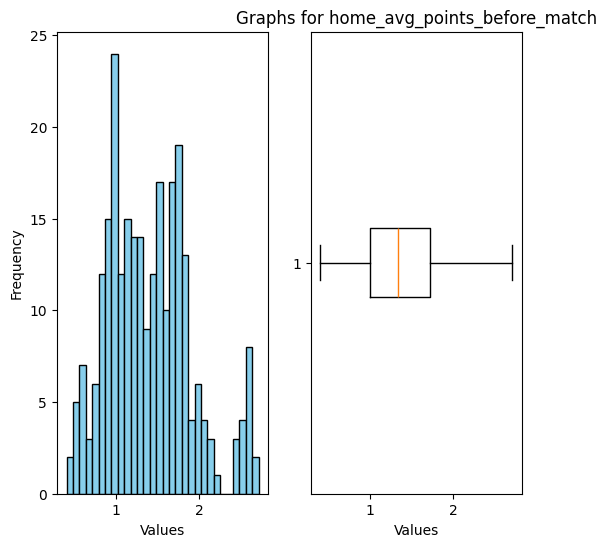

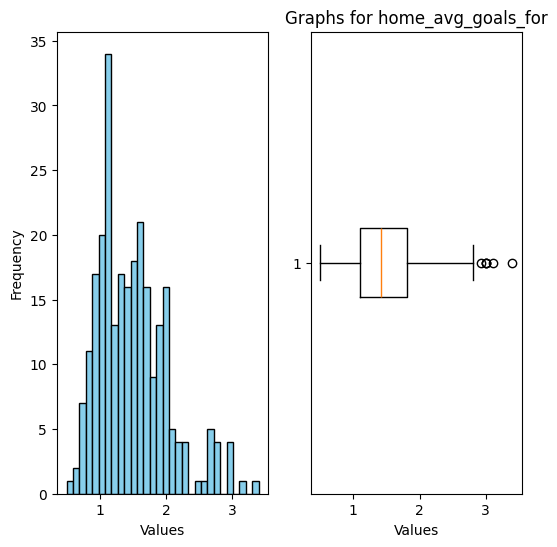

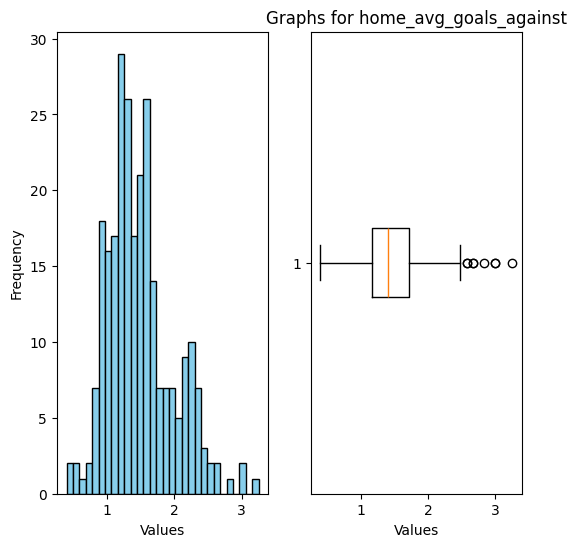

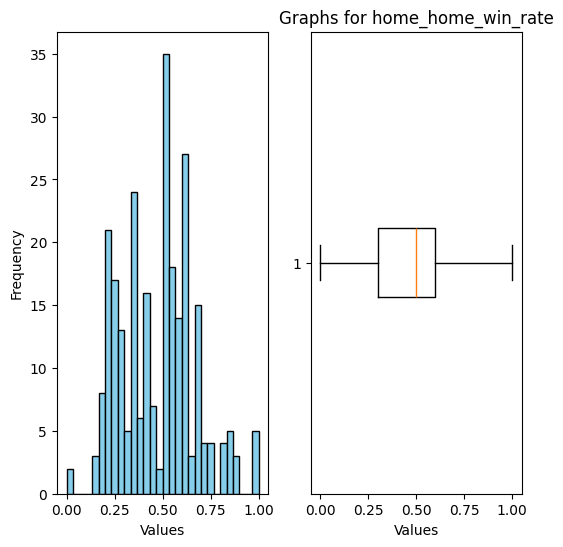

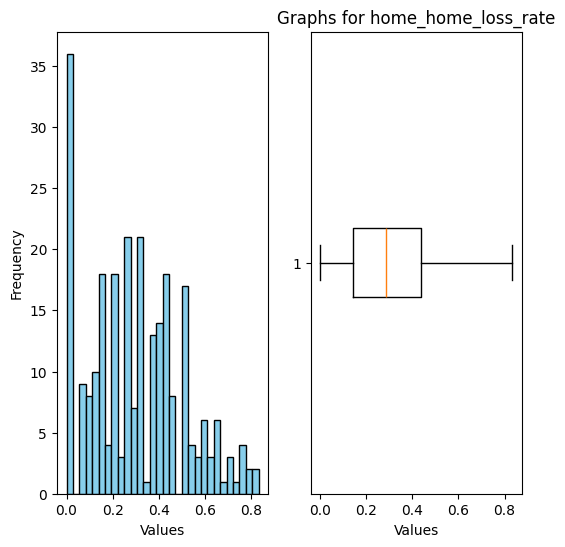

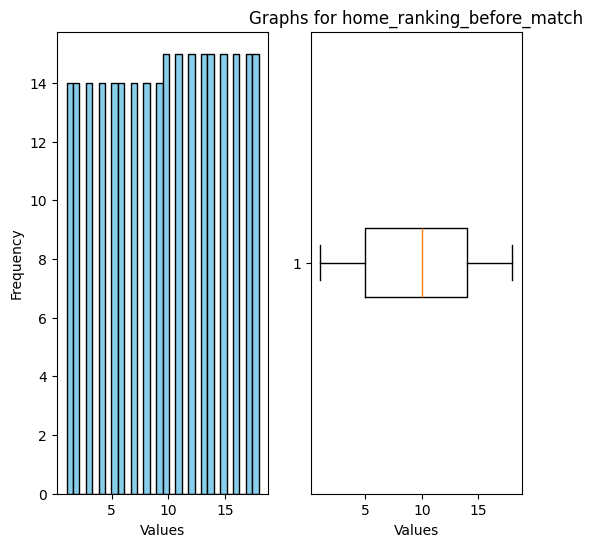

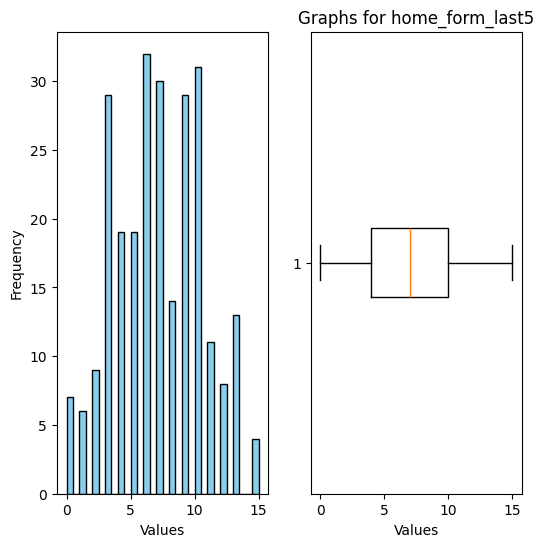

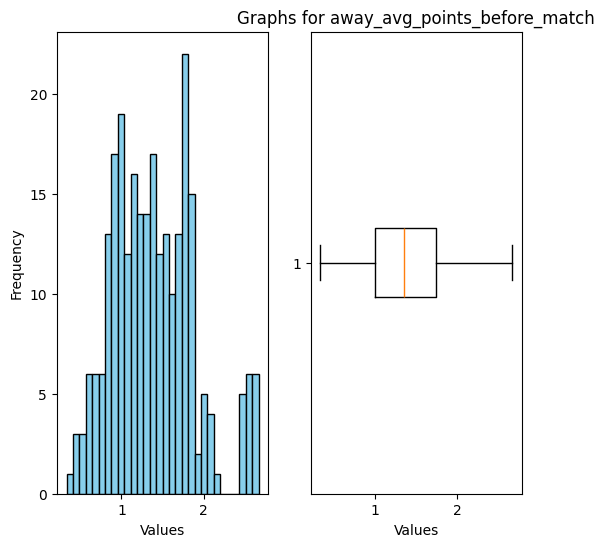

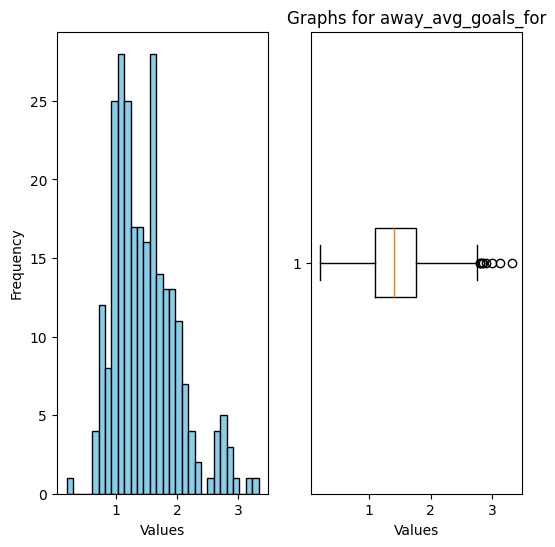

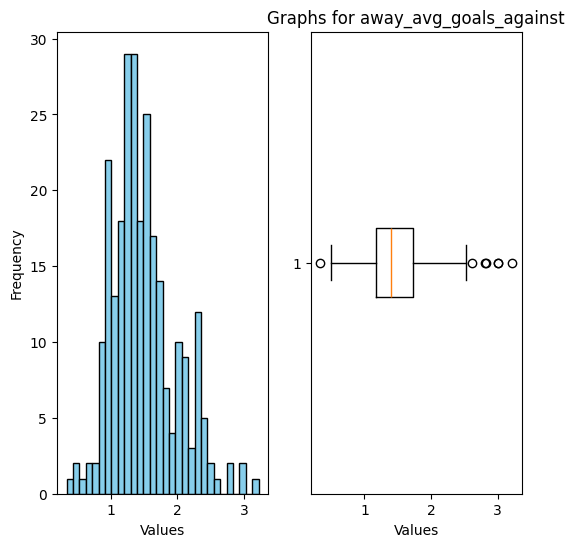

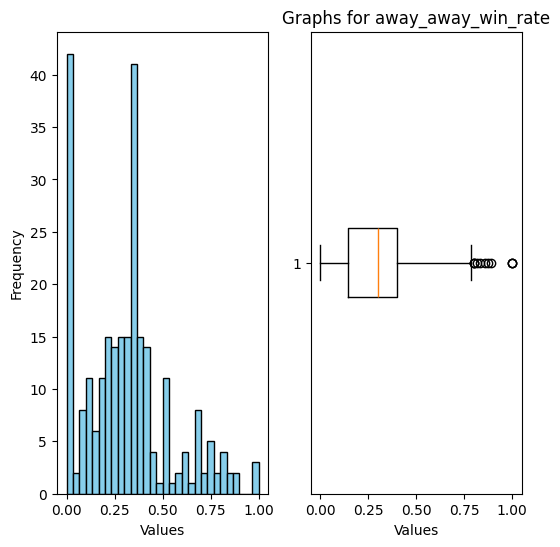

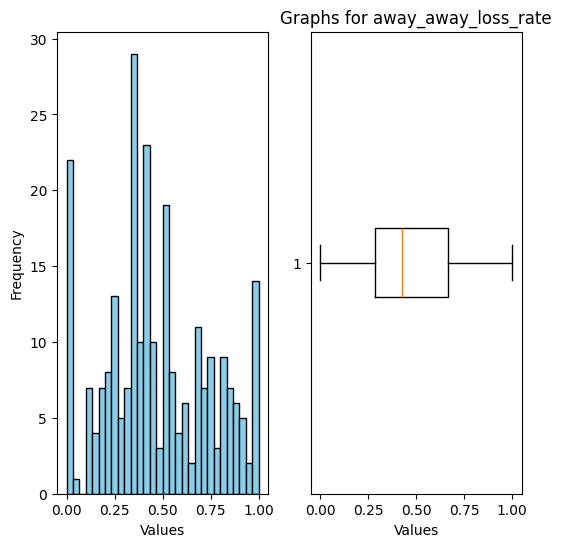

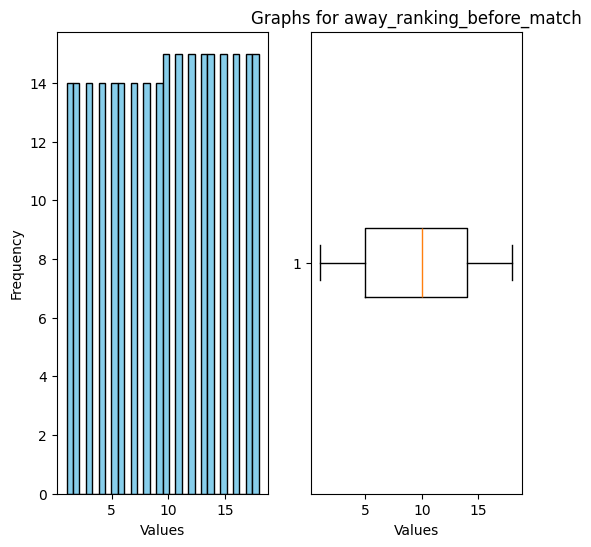

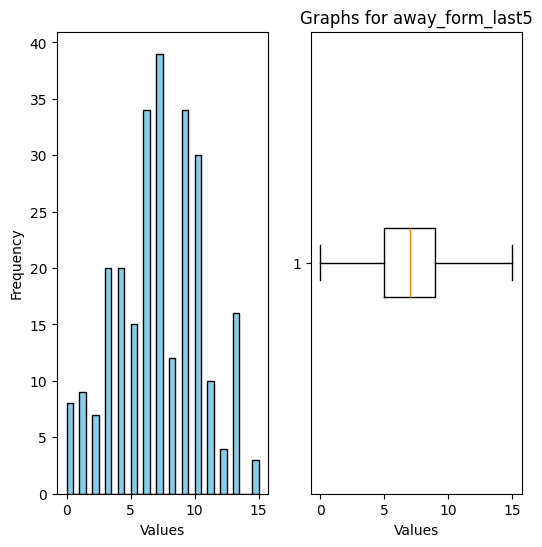

In [70]:
#variable=['home_avg_points_before_match', 'home_avg_goals_for']

for var in variable:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    axs[0].hist(df_for_training[var],bins=30, color='skyblue', edgecolor='black')
    # Adding labels and title
    axs[0].set_xlabel('Values')
    axs[0].set_ylabel('Frequency')
    #axs[0].set_title(f'Basic Histogram of {var}')


    axs[1].boxplot(df_for_training[var],vert=False)
    axs[1].set_xlabel('Values')
    #axs[1].set_title(f'Basic Histogram of {var}')
    plt.title(f"Graphs for {var}")
    # Display the plot
    plt.show()


## 3 Analyse des corrélations

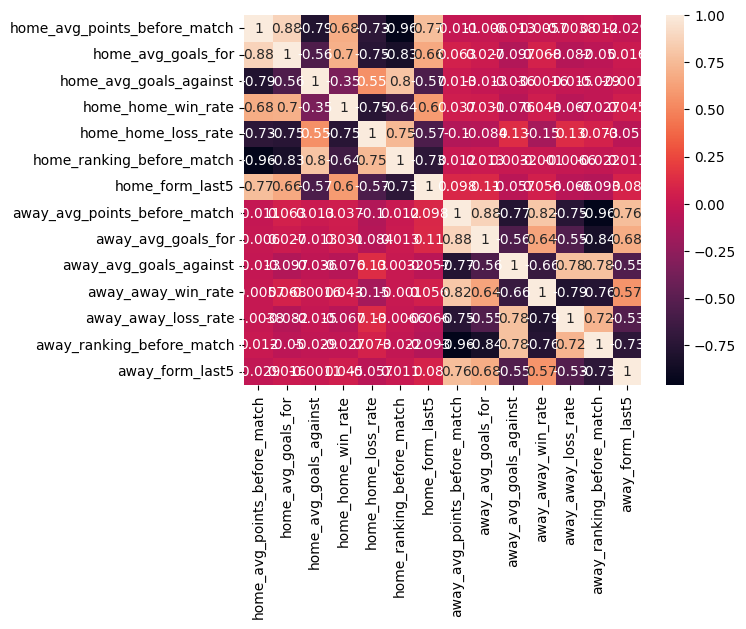

In [ ]:
import seaborn as sns

corr=df_for_training.corr(numeric_only=True)

#plotting the heatmap for correlation
ax = sns.heatmap(corr, annot=True)


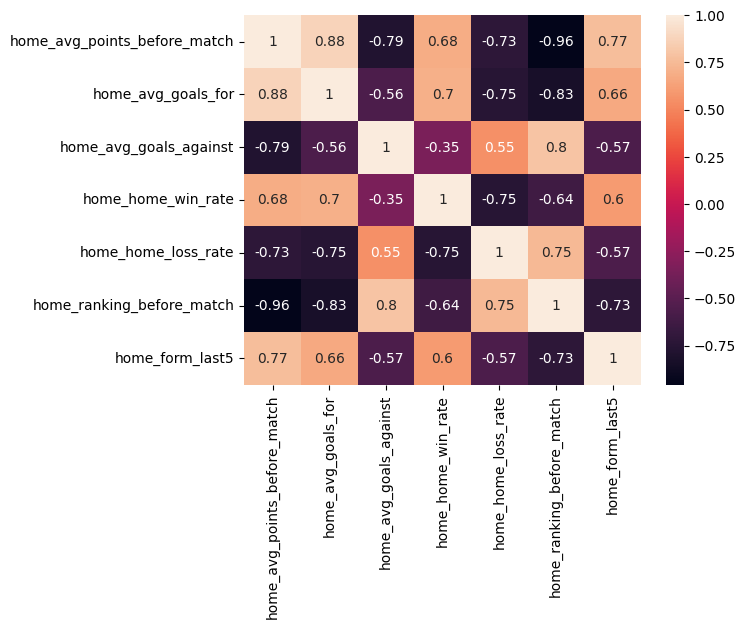

In [115]:
ax = sns.heatmap(corr.iloc[0:7,0:7], annot=True)


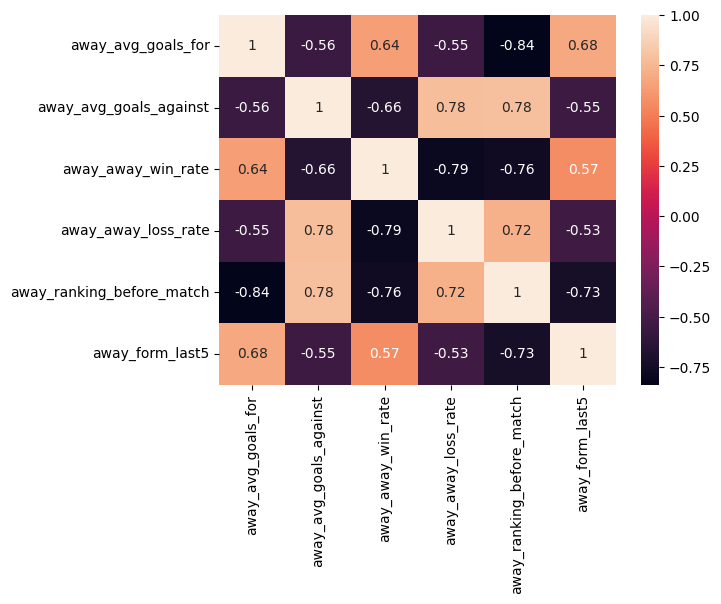

In [116]:

ax = sns.heatmap(corr.iloc[8:15,8:15], annot=True)
